<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/munich/embeddings/gen_review_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for Reviews


In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1225, done.
remote: Counting objects: 100% (1225/1225), done.
remote: Compressing objects: 100% (1158/1158), done.
remote: Total 1225 (delta 737), reused 318 (delta 58), pack-reused 0
Receiving objects: 100% (1225/1225), 10.37 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (737/737), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()
#import explainability_utils as explain

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4


In [3]:
%%capture
!pip install transformers

# Data Loading

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/munich/language/train.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['review_input_ids'], data['review_attention_masks'], data['log_price']

In [6]:
nreviews = np.vectorize(len)(input_ids)

In [7]:
input_ids = np.concatenate(np.array(input_ids))
attention_masks = np.concatenate(np.array(attention_masks))
labels = np.repeat(np.array(labels), nreviews)

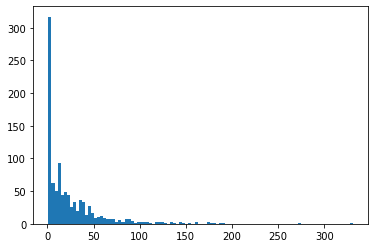

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    string = string[0]
    return len(string.split())

review_lengths = np.vectorize(count_words)(data["reviews_en"])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [9]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [10]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
ids_train, labels_train, masks_train = traindf['review_input_ids'], traindf['log_price'], traindf['review_attention_masks']
ids_val, labels_val, masks_val = valdf['review_input_ids'], valdf['log_price'], valdf['review_attention_masks']
nreviews_train = np.vectorize(len)(ids_train)
nreviews_val = np.vectorize(len)(ids_val)

In [11]:
ids_train, ids_val =  np.concatenate(np.array(ids_train)), np.concatenate(np.array(ids_val))
labels_train, labels_val = np.repeat(np.array(labels_train), nreviews_train), np.repeat(np.array(labels_val), nreviews_val)
masks_train, masks_val = np.concatenate(np.array(masks_train)), np.concatenate(np.array(masks_val))

In [12]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(13392, 128)
(2365, 128)
(13392,)
(2365,)
(13392, 128)
(2365, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [13]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 256
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)

# Generate embeddings

In [14]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best2/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
input_ids, attention_masks, index = data['review_input_ids'], data['review_attention_masks'], data.index

In [23]:
# generate embeddings
embeddings = torch.empty((len(data), 100))
model.eval()
indices = []
with torch.no_grad():
    for i, (ids, masks, idx) in tqdm(enumerate(zip(input_ids, attention_masks, index))):
        ls = []
        single_ids, single_masks = torch.tensor(ids).to(device), torch.tensor(masks).to(device)
        embedding = model.genembeddings(single_ids, single_masks)
        embedding = embedding.detach().cpu().numpy()
        embeddings[i] = torch.tensor(np.mean(embedding, axis=0))
        indices = indices + [idx]
    embeddings[embeddings < 0] = 0 

998it [02:29,  6.69it/s]


In [24]:
# save embeddings in pandas dataframe
df = pd.Series(embeddings.numpy().tolist(), name="reviews", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/munich/embeddings/reviews.pickle"
df.to_pickle(path)

In [18]:
price = data["log_price"].to_numpy()
dataset = TensorDataset(torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(df)[:, np.newaxis])),
                        torch.tensor(price))
dataloader = DataLoader(dataset, batch_size=128)

100%|██████████| 8/8 [00:00<00:00, 121.70it/s]


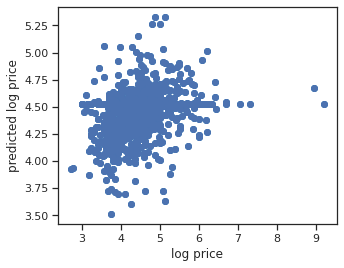

(array([0.30776924042910253], dtype=object), 2.4426091936158303e-23)
The root mean squared error (MSE) on test set: 0.6632


In [19]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for embeddings, labels in tqdm(dataloader):
        embeddings = embeddings.to(device).float()
        y_pred = model.prediction_from_mean(embeddings)
        y_pred = list(y_pred.detach().cpu().numpy())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)

ys = np.array(ys)
ypreds = np.array(ypreds)
m = np.mean(ypreds)
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(ypreds, ys)
ypreds = ypreds * reg.coef_ + reg.intercept_ 
plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

In [20]:
df

159634      [0.0, 0.0, 0.0, 0.910748302936554, 0.0, 1.7827...
170154      [0.0, 0.0, 0.0, 0.9143574237823486, 0.0, 1.770...
170815      [0.0, 0.0, 0.0, 0.9237222075462341, 0.0, 1.803...
186596      [0.0, 0.0, 0.0, 0.9493159055709839, 0.0, 1.837...
190529      [0.0, 0.0, 0.0, 0.8553794026374817, 0.0, 1.695...
                                  ...                        
53875317    [0.0, 0.0, 0.0, 0.9736836552619934, 0.0, 1.908...
53891783    [0.0, 0.0, 0.0, 0.9736836552619934, 0.0, 1.908...
53903590    [0.0, 0.0, 0.0, 0.9736836552619934, 0.0, 1.908...
53929784    [0.0, 0.0, 0.0, 0.9736836552619934, 0.0, 1.908...
53933241    [0.0, 0.0, 0.0, 0.9736836552619934, 0.0, 1.908...
Name: reviews, Length: 998, dtype: object

In [ ]:
mse = mean_squared_error(ys, np.mean(ys) * np.ones(len(ys)))
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.6971


In [ ]:
print(reg.intercept_, reg.coef_)

-1.0151114 [1.3150903]
